## Libraries and Dependencies

In [44]:
import pandas as pd
import torch
from datasets import load_dataset
import regex as re
import unicodedata
import random
random.seed(42)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from transformers import BertForMaskedLM, BertTokenizer

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'cpu'
DEVICE

device(type='cuda')

## Algorithm Implementation

In [16]:
def mask_sentence(sentence, mask_token, i, M, L_min):
    return [mask_token
            if (j - i) % M == 0
            and (len(sentence[j]) >= L_min
                 or sentence[j].startswith('##')
                 or sentence[min(j+1, len(sentence)-1)].startswith('##'))
            else sentence[j]
            for j in range(len(sentence))]

def preprocess_text(text: str) -> str:
     # lower case
     text = text.lower()

     # before normalization : manual handling of contractions and line breaks
     text = text.replace('\n', ' ')
     text = text.replace(' \' ', '\'')
     text = text.replace('\'', ' ')
     text = text.replace('’', ' ')
     text = text.replace('\u0027', ' ')
     print(text)

     # string normalization.
     text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
     text = str(text)[2:-1]

     print(text)
     # the result of previous line adds a few characters to the string,
     # we remove them.

     # remove non alpha numeric characters, except dots, question and exclamation marks that will be needed to separate sentences.
     # text = re.sub(r'[^\w]', ' ', text)

     # replace numbers by the <NUM> token.
     text = re.sub(r'[0-9]+', '<NUM>', text)
     print(text)

     # remove double whitespaces.
     text = re.sub(r'( ){2,}', ' ', text).strip()
     print(text)
     # removing spaces at beginning and end of string.

     return text

In [72]:
def BLANC_help(sentence, translation, model, tokenizer, M=6, L_min=4, sep='[SEP]', device = DEVICE):
    """
    Calculates BLANC score between a given sentence and its translation using a specified model.

    Parameters:
    - sentence (List[str]): A tokenized sentence.
    - translation (List[str]): The tokenized translation.
    - model: BERT-type model
    - tokenizer: The tokenizer associated with the model used.
    - M (int): Parameter M for the algorithm (default is 6).
    - L_min (int): Minimum length requirement for masked words (default is 4).
    - sep (str): Separator between the inference help (filler/summary) and a sentence from the text (default is '[SEP]').

    Returns:
    - float: BLANC score for the given sentence and its translation.
    """
    filler = ['.'] * len(translation)
    S = [[0, 0], [0, 0]]

    for i in range(M):
        masked_sentence = mask_sentence(sentence, tokenizer.mask_token, i, M, L_min)
        print(masked_sentence)

        #input_base = tokenizer.tokenize("Français:") + filler + [sep] + tokenizer.tokenize("English:") + masked_sentence
        #input_help = tokenizer.tokenize("Français:") + translation + [sep] + tokenizer.tokenize("English:") + masked_sentence

        input_base = filler + [sep] + masked_sentence
        input_help = translation + [sep] + masked_sentence

        print(input_base)
        print(input_help)

        tokenized_input_base = torch.tensor(tokenizer.convert_tokens_to_ids(input_base)).to(device) # Shape: [sequence_length]
        tokenized_input_help = torch.tensor(tokenizer.convert_tokens_to_ids(input_help)).to(device) # Shape: [sequence_length]

        out_base = model(input_ids=tokenized_input_base.unsqueeze(0)).logits  # Shape: [1, sequence_length, model_vocab_size]
        out_help = model(input_ids=tokenized_input_help.unsqueeze(0)).logits  # Shape: [1, sequence_length, model_vocab_size]

        out_base = torch.argmax(out_base.squeeze(0), dim=-1)  # Shape: [sequence_length]
        out_help = torch.argmax(out_help.squeeze(0), dim=-1)  # Shape: [sequence_length]

        masked_tokens = [idx for idx, word in enumerate(masked_sentence) if word == tokenizer.mask_token]

        for j in masked_tokens:
            idx = len(translation + [sep]) + j 
            predicted_word_base = tokenizer.convert_ids_to_tokens(out_base[idx].item())
            predicted_word_help = tokenizer.convert_ids_to_tokens(out_help[idx].item())

            print(f'predicted_word_base[{idx - len(translation + [sep])}]: {predicted_word_base}')
            print(f'predicted_word_help[{idx - len(translation + [sep])}]: {predicted_word_help}')
            print(f'sentence[{j}]: {sentence[j]}')

            k = int(predicted_word_base == sentence[j])
            m = int(predicted_word_help == sentence[j])
            S[k][m] += 1

    if (S[0][0] + S[1][1] + S[0][1] + S[1][0]) == 0:
        B = 0
    else:
        B = (S[0][1] - S[1][0]) / (S[0][0] + S[1][1] + S[0][1] + S[1][0])

    return B

## Datasets

In [5]:
en_fr_ds = load_dataset('news_commentary', 'en-fr', split='train')
en_fr_ds

Dataset({
    features: ['id', 'translation'],
    num_rows: 209479
})

In [64]:
en_fr_df = pd.read_csv("en_to_fr_translations.csv", index_col=0)
en_fr_df

for i in range(20):
    t = en_fr_df.loc[i*5 + 1, "fr"].split()
    random.shuffle(t)
    t = " ".join(t)
    en_fr_df.loc[i*5 + 4, "fr"] = t



In [6]:
en_fr_df = pd.DataFrame(en_fr_ds['translation'][:300])
# en_fr_df['en'] = en_fr_df['en'].apply(lambda x : preprocess_text(x))
# en_fr_df['fr'] = en_fr_df['fr'].apply(lambda x : preprocess_text(x))
# en_fr_df

In [47]:
# en_sent = ["Although Abdullah is usually referred to in the West as Saudi Arabia's ruler, the debilitated King Fahd's six full brothers are the ones who truly represent the real power in the Kingdom. Almost nothing, neither in support nor in opposition, has been uttered by the King and these other brothers, collectively known as the \"Sudairis\"."]*5 \
# + ["America's seemingly hostile attention gave rise to the speculation that Crown Prince Abdullah's initiative really denotes a Saudi public relations counteroffensive, hatched in the Saudi embassy in Washington to cover over the rift with the US. Indeed, the subsequent, deafening silence by other Saudi leaders to the proposal appears to confirm it as a public relations move for which they need not risk any of their own domestic political capital."]*5 \
# + ["His scholarly training and rhetorical gifts supplemented each other in a rare fashion."]*5 \
# + ["Alas, there is no single or silver bullet."]*5 \
# + ["Unfortunately, this turned out to be the wrong thing to do, as the monetarist interpretation of the Great Depression was, to put it bluntly, wrong in significant respects and radically incomplete."]*5 \
# + ["Could the French and the British feel as spiritually at home in Europe as they feel in their national states?"]*5 \
# + ["Last week, the United States Supreme Court ruled that detainees at Guantánamo Bay have the right to habeas corpus - the right to challenge the factual and legal basis of their detention in a court of law. I was elated by the decision, having spent four years working on ensuring the rule of law in US detention and interrogation policy, including monitoring military commission trials at Guantánamo Bay. But my happiness is tempered by where I sit, close to the border with Zimbabwe – a country where the writ of habeas corpus and the rule of law have become obsolete."]*5 \
# + ["China's leaders, however, tend to suspect that the US is deliberately trying to undermine their country's political stability by questioning its record on human rights and political freedoms."]*5 \
# + ["But, when it comes to standards - such as those governing safety, health, and the environment - the market-access requirements are brutal and binary: either you meet the established standard or you do not sell."]*5 \
# + ["Were they to abandon nuclear energy, however, their epochal change of heart would constitute a seminal contribution to global nuclear security - and thus to the fight against nuclear proliferation."]*5 \
# + ["Second, drug development is geared toward maximizing profit, not social benefit, which skews efforts directed at the creation of medicines that are essential to human welfare."]*5 \
# + ["This makes sense."]*5 \
# + ["Governments must not be given the power to control its citizens' moral code - we know that if they had such power, they would misuse it."]*5 \
# + ["To an economist, the problem is obvious: polluters are not paying the full costs of the damage they cause."]*5 \
# + ["Indeed, broader access to financial services would help the estimated 400 million micro, small, and medium-size enterprises in developing countries to prosper, while enabling the 2.5 billion people worldwide who currently lack access to such services to build their assets."]*5 \
# + ["PRINCETON - What we are doing to our planet, to our children and grandchildren, and to the poor, by our heedless production of greenhouse gases, is one of the great moral wrongs of our age."]*5 \
# + ["If firewalls are strong, or redundancy and resilience allow quick recovery, or the prospect of a self-enforcing response (“an electric fence”) seems possible, an attack becomes less attractive."]*5 \
# + ["THE HAGUE - The war in Afghanistan, now approaching its tenth year, may seem to many to have no end in sight, but Latin America has endured an even longer fight, one that has recently become much more bloody: the “war” against drug trafficking."]*5 \
# + ["That caricature, if ever true, is certainly not true today: the business community's negative reaction to the persecution of Khodorkovsky by the law enforcement agencies has been strong and nearly unanimous."]*5 \
# + ["In our quest for structure and predictability - a natural impulse in times of rapid change - we are desperate for hints about how the world, and our role in it, will develop."]*5

In [48]:
# t = "Bien qu'Abdallah soit généralement considéré en Occident comme le dirigeant de l'Arabie saoudite, les six frères germains du roi Fahd, gravement malade, sont ceux qui détiennent vraiment les rennes du pouvoir dans le royaume. Le roi et ses frères, reconnus collectivement sous le nom de \"Soudairis\", n'ont presque rien dit pour soutenir ou rejeter cette proposition.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent = ["Bien qu'Abdallah soit généralement considéré en Occident comme le dirigeant de l'Arabie saoudite, les six frères germains du roi Fahd, gravement malade, sont ceux qui détiennent vraiment les rennes du pouvoir dans le royaume. Le roi et ses frères, reconnus collectivement sous le nom de \"Soudairis\", n'ont presque rien dit pour soutenir ou rejeter cette proposition."] \
# + ["Bien qu'Abdallah soit généralement considéré à l'Ouest comme le dirigeant de l'Arabie saoudite, les six frères du roi Fahd, affaibli, sont ceux qui représentent véritablement le pouvoir dans le royaume. Presque rien n'a été dit ni en faveur ni en opposition par le roi et ces autres frères, collectivement connus sous le nom de \"Sudairis\"."] \
# + ["Bien qu'Abdullah soit désigner dans l'ouest comme le directeur de l'Arabie saoudite, les six frères à part entière du roi débilité Fahd sont ceux qui représente vraiment le pouvoir réel dans le royaume. Presque rien ni en pour ni en contre, n'a été dit par le roi et ses autres frères connus sous le nom de \"Sudairis\"."] \
# + ["Abdullah est souvent désigné dans l'ouest comme le directeur de l'Arabie saoudite, mais les six frères à part entière du roi débilité Fahd ce sont eux qui représentent vraiment le vrai pouvoir réel dans le royaume. Presque rien, ni en plus ni en moins, n'est par le roi et ces autres frères, connus comme les \"Sudairis\"."] \
# + [t]

# t = "L'attention apparemment hostile de l'Amérique a donné naissance aux spéculations sur l'initiative du prince héritier Abdallah, qui serait la marque de la contre-offensive saoudienne en matière de relations publiques, tramée à l'ambassade saoudienne de Washington pour masquer le désaccord entre ces deux pays. De fait, le silence assourdissant qui s'en suivit chez les dirigeants saoudiens semblerait confirmer que cette proposition n'est qu'un geste de relation publique pour lequel il n'est nul besoin de mettre en danger leur propre capital intérieur.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("L'attention apparemment hostile de l'Amérique a donné naissance aux spéculations sur l'initiative du prince héritier Abdallah, qui serait la marque de la contre-offensive saoudienne en matière de relations publiques, tramée à l'ambassade saoudienne de Washington pour masquer le désaccord entre ces deux pays. De fait, le silence assourdissant qui s'en suivit chez les dirigeants saoudiens semblerait confirmer que cette proposition n'est qu'un geste de relation publique pour lequel il n'est nul besoin de mettre en danger leur propre capital intérieur.")
# fr_sent.append("L'attention apparemment hostile de l'Amérique a donné lieu à des spéculations selon lesquelles l'initiative du prince héritier Abdullah constitue en réalité une contre-offensive saoudienne de relations publiques, élaborée à l'ambassade saoudienne à Washington pour masquer le fossé avec les États-Unis. En effet, le silence assourdissant des autres dirigeants saoudiens face à cette proposition semble confirmer qu'il s'agit d'une opération de relations publiques pour laquelle ils n'ont pas besoin de risquer leur propre capital politique intérieur.")
# fr_sent.append("L'attention hostile des États-Unis à donné lieu à la spéculation que l'initiative du prince héritier Abdullah dénote vraiment une contre-offensive saoudienne de relations publiques, née dans l'ambassade saoudienne à Washington pour couvrir la fracture avec les États-Unis. En effet, le silence assourdissant des autres dirigeants saoudiens sur la proposition semble le confirmé qu'il serait comme un mouvement de relations publiques pour lesquelles ils ne doivent pas risquer leur propre capital politique national.")
# fr_sent.append("L'attention méchante des États-Unis à engendré l'idée que l'initiative du prince héritier Abdullah est vraiment une contre-offensive saoudienne des relations publiques, née dans l'ambassade saoudienne à Washington pour semer le doute de la fracture avec les États-Unis. Le silence sombre des autres dirigeants arabes sur la proposition ont l'air de le confirmé qu'il serait comme un mouvement de relations publiques pour lesquelles ils ne doivent pas du tout risquer leur capital politique de la nation.")
# fr_sent.append(t)

# t = "Sa formation universitaire et ses dons pour la rhétorique se complétaient l'un l'autre pour former un tout unique.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("Sa formation universitaire et ses dons pour la rhétorique se complétaient l'un l'autre pour former un tout unique.")
# fr_sent.append("Sa formation académique et ses dons rhétoriques se complètaient de manière rare.")
# fr_sent.append("Son éducation scientifique et ses dons de rhétorique se complétent de manière rare.")
# fr_sent.append("Son éducation à l'école et sa parole avantageuse se complètent à la mode.")
# fr_sent.append(t)

# t = "Hélas, il n'existe aucune solution miracle.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("Hélas, il n'existe aucune solution miracle.")
# fr_sent.append("Hélas, il n'existe pas de solution unique ou miracle.")
# fr_sent.append("Hélas, la solution miracle n'est pas existante.")
# fr_sent.append("Malheureusement, il n'y a pas de balle argentée.")
# fr_sent.append(t)

# t = "Malheureusement cela s'est avéré un mauvais choix, puisque l'interprétation monétariste de la Grande Dépression, pour le dire crûment, a eu tort sur bien des aspects importants et s'est montrée radicalement incomplète.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("Malheureusement cela s'est avéré un mauvais choix, puisque l'interprétation monétariste de la Grande Dépression, pour le dire crûment, a eu tort sur bien des aspects importants et s'est montrée radicalement incomplète.")
# fr_sent.append("Malheureusement, cela s'est avéré être la mauvaise chose à faire, car l'interprétation monétariste de la Grande Dépression était, pour le dire franchement, erronée à bien des égards et radicalement incomplète.")
# fr_sent.append("Malheureusement, cela s'est révélé être une mauvaise chose, car l'interprétation monétariste de la Grande Dépression était, pour le mettre sans détour, mauvaises dans des domaines importants et radicalement incomplète.")
# fr_sent.append("Malheureusement, c'était mauvais car interpréter monétairement la Grande Dépression était pour dire les choses directement mal et franchement incomplet.")
# fr_sent.append(t)

# t = "Les Français et les Anglais pourraient-ils se sentir aussi spirituellement chez eux en Europe qu'ils le sont dans leur état national ?".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("Les Français et les Anglais pourraient-ils se sentir aussi spirituellement chez eux en Europe qu'ils le sont dans leur état national ?")
# fr_sent.append("Les Français et les Britanniques pourraient-ils se sentir spirituellement chez eux en Europe comme ils se sentent chez eux dans leurs États nationaux ?")
# fr_sent.append("Les Français et les Anglais peuvent-ils se sentir aussi spirituellement chez eux en Europe que dans leurs États nationaux ?")
# fr_sent.append("Les Français et les Anglais peuvent-ils être comme spirituel à la maison en Europe plutôt que dans leur État national ?")
# fr_sent.append(t)

# t = "La semaine dernière, la Cour suprême des USA a décidé que les prisonniers de Guantanamo ont droit à l'habeas corpus - le droit de contester le fondement juridique et factuel de leur détention devant un tribunal. Ayant travaillé pendant 4 ans au respect de la loi dans les prisons et à la légalité des méthodes d'interrogatoire aux USA, ainsi qu'à la régularité des procès devant la commission militaire de Guantanamo, je ne peux qu'applaudir cette décision. Mais mon bonheur est mitigé de par l'endroit où je me situe, près de la frontière avec le Zimbabwe, où l'habeas corpus et l'État de droit sont tombées en désuétude.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("La semaine dernière, la Cour suprême des USA a décidé que les prisonniers de Guantanamo ont droit à l'habeas corpus - le droit de contester le fondement juridique et factuel de leur détention devant un tribunal. Ayant travaillé pendant 4 ans au respect de la loi dans les prisons et à la légalité des méthodes d'interrogatoire aux USA, ainsi qu'à la régularité des procès devant la commission militaire de Guantanamo, je ne peux qu'applaudir cette décision. Mais mon bonheur est mitigé de par l'endroit où je me situe, près de la frontière avec le Zimbabwe, où l'habeas corpus et l'État de droit sont tombées en désuétude.")
# fr_sent.append("La semaine dernière, la Cour suprême des États-Unis a statué que les détenus de Guantánamo Bay avaient le droit à l'habeas corpus, c'est-à-dire le droit de contester la base factuelle et juridique de leur détention devant un tribunal. Cette décision m'a réjoui, car j'ai passé quatre ans à veiller au respect de l'État de droit dans la politique américaine en matière de détention et d'interrogatoire, notamment en suivant les procès de la commission militaire à Guantánamo Bay. Mais ma joie est tempérée par l'endroit où je me trouve, près de la frontière avec le Zimbabwe, un pays où l'habeas corpus et l'État de droit sont devenus obsolètes.")
# fr_sent.append("La semaine dernière, la Cour suprême des États-Unis a prononcé que les détenus de Guantánamo Bay ont le droit d'habeas corpus - le droit de disputer le fondement factuel et juridique de leur détention devant un tribunal. J'ai été ravi de la décision, après avoir passé quatre ans à travailler pour assurer l'état de droit dans la politique américaine de détention et d'interrogatoire, y compris la surveillance des procès de la commission militaire à Guantánamo Bay. Mais mon bonheur est modéré par là où je suis assis, près de la frontière avec le Zimbabwe - un pays où le bref d'habeas corpus et la primauté du droit sont devenus périmés.")
# fr_sent.append("La semaine passée, la Cour des suprême États-Unis a proféré : les prisonniers de Guantánamo Bay ont le droit d'habeas corpus - ils disputent la base de faits et juridique de s'ils sont détenus devant le tribunal. Je suis content, comme j'ai travaillé quatre ans dans l'assurance de l'état de droits dans la politique américaine de détention et d’interrogatoire, aussi la surveillance des procès de la commission militarisée à Guantánamo Bay. Mais je ne suis pas heureux là où je suis assis, à coté de la ligne séparatrice avec le Zimbabwe - un pays dans lequel l'habeas corpus et la règle de loi sont morts.")
# fr_sent.append(t)

# t = "Cependant les dirigeants de la Chine ont tendance à suspecter que les États-Unis tentent délibérément de porter atteinte à la stabilité politique de leur pays en remettant en cause son bilan en matière de droits et de libertés politiques.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("Cependant les dirigeants de la Chine ont tendance à suspecter que les États-Unis tentent délibérément de porter atteinte à la stabilité politique de leur pays en remettant en cause son bilan en matière de droits et de libertés politiques.")
# fr_sent.append("Les dirigeants chinois ont toutefois tendance à soupçonner les États-Unis d'essayer délibérément de saper la stabilité politique de leur pays en remettant en question son bilan en matière de droits de l'homme et de libertés politiques.")
# fr_sent.append("Les dirigeants chinois ont tout de même la tendance de penser que les États-Unis veulent essayer délibérément de compromettre la politique stabilité de leur pays en remettant en question ses dossiers sur les droits humain et de libertés politiques.")
# fr_sent.append("Les dirigeants de chine ont pensé que les États-Unis veulent essayer délibérément de sous miner la stable politique du pays et se pose des questions sur ses dossiers sur les droits humain et de libertés politiques.")
# fr_sent.append(t)

# t = "Mais quand il s'agit des normes - de celles qui touchent à la sécurité, à la santé et à l'environnement - les conditions d'accès au marché sont brutales et binaires : ou bien vous répondez aux normes en vigueur, ou bien vous ne vous vendez pas.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("Mais quand il s'agit des normes - de celles qui touchent à la sécurité, à la santé et à l'environnement - les conditions d'accès au marché sont brutales et binaires : ou bien vous répondez aux normes en vigueur, ou bien vous ne vous vendez pas.")
# fr_sent.append("Mais quand il s'agit des normes - telles que ceux qui touchent à la sécurité, à la santé et à l'environnement - les conditions d'accès au marché sont brutales et binaires : tu te confortes au standard ou tu ne vends pas.")
# fr_sent.append("Mais lorsqu'il est question des standards - comme celles en rapport avec la sécurité, à la santé et à l'environnement - les conditions d'accès au marché sont brutales et binaires - où vous répondez aux normes en vigueur où tu ne vends pas.")
# fr_sent.append("Quand il s'agit des classiques - comme ceux gouvernant la sécurité, santé et l'environnement - la nécessité d'accès au marché est brutale et binaire : vous rencontrez le standard établi où tu ne vends pas.")
# fr_sent.append(t)

# t = "Mais si elles décidaient de renoncer à l'énergie nucléaire, leur revirement serait une contribution marquante à la sécurité nucléaire mondiale - et donc à la lutte contre la prolifération nucléaire.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("Mais si elles décidaient de renoncer à l'énergie nucléaire, leur revirement serait une contribution marquante à la sécurité nucléaire mondiale - et donc à la lutte contre la prolifération nucléaire.")
# fr_sent.append("Seraient-ils prêts à abandonner l'énergie nucléaire, leur changement d'avis constituerai une contribution majeure pour la sécurité nucléaire globale - et donc pour le combat contre la prolifération nucléaire.")
# fr_sent.append("Seraient-elles a abandonnaient l'énergie nucléaire, leur changement de coeur constiturait une grande contribution pour la sécurité nucléaire mondiale - et donc contre le combat de prolifération nucléaire.")
# fr_sent.append("Sont-ils à abandonner l'énergie nucléaire, cependant, leur changement d'époque de coeur constituerait une contribution séminale à la sécurité nucléaire globale - et ainsi pour le combat contre la foisonnement nucléaire.")
# fr_sent.append(t)

# t = "Deuxièmement, la production pharmaceutique est axée sur une maximisation des profits, plutôt que sur les bienfaits sociaux, ce qui entrave les efforts en faveur de la création de médicaments essentiels au bien être humain.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("Deuxièmement, la production pharmaceutique est axée sur une maximisation des profits, plutôt que sur les bienfaits sociaux, ce qui entrave les efforts en faveur de la création de médicaments essentiels au bien être humain.")
# fr_sent.append("Deuxièmement, le développement de médicaments vise à maximiser le profit et non le bénéfice social, ce qui dévie les efforts visant à créer des médicaments essentiels au bien-être humain.")
# fr_sent.append("Deuxièmement, le développement des médicaments est orienté vers maximiser les profits, pas le bénéfice social, ce qui dévie les efforts dirigés à la création des médicaments qui sont essentials au bien être des êtres humains.")
# fr_sent.append("Deuxième, le développement des drogues et diriger vers maximiser le profit, pas le bénéfice sociaux, ce qui dévie les efforts dirigés vers créer vers créer des médecins qui sont essentiels aux humains.")
# fr_sent.append(t)

# t = "C'est logique.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("C'est logique.")
# fr_sent.append("C'est sensé.")
# fr_sent.append("Ça fait du sens.")
# fr_sent.append("Ceci fait sensation.")
# fr_sent.append(t)

# t = "Les gouvernements ne doivent pas détenir le pouvoir de contrôler le code moral de leurs citoyens - nous savons bien que s'ils avaient ce pouvoir, ils en abuseraient.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("Les gouvernements ne doivent pas détenir le pouvoir de contrôler le code moral de leurs citoyens - nous savons bien que s'ils avaient ce pouvoir, ils en abuseraient.")
# fr_sent.append("Les gouvernements ne doivent pas se voir donner le pouvoir de contrôler le code moral de leurs citoyens - nous savons que s'ils disposaient d'un tel pouvoir, ils en feraient un mauvais usage.")
# fr_sent.append("Les gouvernements ne doivent pas obtenir le pouvoir de controler le code moral de ses citoyens - on sait que s'ils le pouvaient, ils le maltraiteraient.")
# fr_sent.append("Les gouvernements ne devraient pas être donnés pour le pouvoir de controler ces citoyens - on sait que si ils pouvaient ils le feraient mal.")
# fr_sent.append(t)

# t = "Pour un économiste, le problème paraît évident : les pollueurs ne payent pas l'ensemble des dommages dont ils sont coupables.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("Pour un économiste, le problème paraît évident : les pollueurs ne payent pas l'ensemble des dommages dont ils sont coupables.")
# fr_sent.append("Pour un économiste, le problème est évident : les pollueurs ne payent pas les frais complets des dommages qu'ils causent.")
# fr_sent.append("Pour l'économiste, le problème est clair : les pollueurs ne payent pas les dommages qu'ils ont faits.")
# fr_sent.append("Pour l'économie, le problème est clair : la pollution n'est pas payée par les pollueurs qui la font.")
# fr_sent.append(t)

# t = "Un accès plus étendu aux services financiers aiderait en effet un nombre estimé de 400 millions de microentreprises et de PME à prospérer dans les pays en développement, tout en permettant à 2,5 milliards de personnes qui n'ont pas actuellement accès à de tels services de se bâtir un avoir.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("Un accès plus étendu aux services financiers aiderait en effet un nombre estimé de 400 millions de microentreprises et de PME à prospérer dans les pays en développement, tout en permettant à 2,5 milliards de personnes qui n'ont pas actuellement accès à de tels services de se bâtir un avoir.")
# fr_sent.append("En effet, un accès plus large aux services financiers aiderait une estimation de 400 millions de micro, petites et moyennes entreprises des pays en développement à prospérer, tout en permettant aux 2,5 milliards de personnes dans le monde qui actuellement manquent d'accès à ces services de constituer leurs actifs.")
# fr_sent.append("En effet, un accès plus large aux services de financement aideraient l'estimé 400 micro millions de petites et moyenne entreprises pour développer des pays et prospérer, pendant qu'activer les 2.5 milliards de personnes dans le monde qui en ce moment manquent d'accès aux services pour construire leurs atouts.")
# fr_sent.append("Et oui, accéder large aux services de finance peut aider l'estimé 400 micro millions de petites, moyenne tailles entreprises pour développer des pays pour prospérer, pendant qu'activer les 2.5 milliards de personnes mondiales qui maintenant manquent d'un accès à des services pour construire leurs atouts.")
# fr_sent.append(t)

# t = "PRINCETON - Ce que nous infligeons à notre planète, à nos enfants et à nos petits enfants, et aux plus démunis, par notre insouciante production de gaz à effet de serre, est une des offenses majeures de notre ère.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("PRINCETON - Ce que nous infligeons à notre planète, à nos enfants et à nos petits enfants, et aux plus démunis, par notre insouciante production de gaz à effet de serre, est une des offenses majeures de notre ère.")
# fr_sent.append("PRINCETON - Ce que nous faisons à notre planète, à nos enfants et petits-enfants, et aux pauvres, par notre production inconsidérée de gaz à effet de serre, est l'un des plus grandes fautes morales de notre époque.")
# fr_sent.append("PRINCETON - Ce que nous faisons à notre terre, à nos enfants et petits enfants, et aux pauvres, par notre production sans tête de gaz de maison verte, est l'une des grandes fautes morales de notre âge.")
# fr_sent.append("PRINCETON - Ce qu'on fait à la planète, à nos enfants et petits enfants, et à les pauvres, à cause de notre production sans tête de gaz de maison verte, est l'un des super faux moraux de notre âge.")
# fr_sent.append(t)

# t = "Si les pare-feux sont solides, ou si la redondance et la résilience permettent un rétablissement prompt, ou si la perspective d'une réplique automatique par l'entité visée (\"une barrière électrique\") paraît possible, alors une attaque devient moins intéressante.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("Si les pare-feux sont solides, ou si la redondance et la résilience permettent un rétablissement prompt, ou si la perspective d'une réplique automatique par l'entité visée (\"une barrière électrique\") paraît possible, alors une attaque devient moins intéressante.")
# fr_sent.append("Si les pare-feux sont puissants, si la redondance et la résilience permettent une récupération rapide, ou si la perspective d'une réponse auto-exécutoire (\"une clôture électrique\") semble possible, une attaque devient moins attrayante.")
# fr_sent.append("Si les pare-feux sont forts, ou si la redondance et l'élasticité permettent un rétablissement rapide, ou si l'éventuelle réponse auto-applicable (\"une clôture électrique\") semble possible, une attaque se fait moins attrayante.")
# fr_sent.append("Si les murs de feu sont forts, ou si être redondant et élastique permettent un rétablissement vif, ou si le prospectus de réponse auto-imposée (\"une clôture électrique\") a l'air possible, l'attaque est moins belle.")
# fr_sent.append(t)

# t = "LA HAYE - La guerre en Afghanistan, un conflit que beaucoup considèrent sans fin, aura bientôt dix ans. Pourtant, l'Amérique latine est aussi en proie à d'interminables affrontements. Il s'agit de la \"guerre\" contre le trafic de drogue, dont les effusions de sang se sont récemment accrues.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("LA HAYE - La guerre en Afghanistan, un conflit que beaucoup considèrent sans fin, aura bientôt dix ans. Pourtant, l'Amérique latine est aussi en proie à d'interminables affrontements. Il s'agit de la \"guerre\" contre le trafic de drogue, dont les effusions de sang se sont récemment accrues.")
# fr_sent.append("LA HAYE - La guerre en Afghanistan, approchant maintenant ses dix ans, semble pour beaucoup ne pas avoir de fin en vue, mais l'Amérique latine a enduré un combat encore plus long, un qui est récemment devenu bien plus sanglant: la \"guerre\" contre le traffic de drogue.")
# fr_sent.append("LA HAYE - La guerre en Afghanistan, qui se rapproche maintenant de sa dixième année, semble pour plein de gens ne pas avoir de fin, mais l'Amérique latine a supporté un combat encore plus long, un qui est récemment devenu bien plus ensanglanté: la \"guerre\" contre le traffic de drogue.")
# fr_sent.append("LA HAYE - La guerre en Afghanistan, qui approche maintenant des dix ans, semble de partout ne pas avoir de fin visuelle, mais l'Amérique latine à durer un combat encore plus long terme, un qui est devenu bien plus saignant il n'y a pas longtemps: la \"guerre\" contre trafiquer des médicaments.")
# fr_sent.append(t)

# t = "Cette caricature, si elle s'est jamais appliquée, n'est certainement plus vraie aujourd'hui : la réaction négative de la communauté économique envers la persécution de Khodorkovsky par les organismes chargés de l'application de la loi a été forte et quasiment unanime.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("Cette caricature, si elle s'est jamais appliquée, n'est certainement plus vraie aujourd'hui : la réaction négative de la communauté économique envers la persécution de Khodorkovsky par les organismes chargés de l'application de la loi a été forte et quasiment unanime.")
# fr_sent.append("Cette caricature, si elle a jamais été vraie, ne l'est certainement pas aujourd'hui : la réaction négative des milieux d'affaires à la persécution de Khodorkovsky par les forces de l'ordre a été forte et presque unanime.")
# fr_sent.append("Cette caricature, si elle a un jour été vraie, ne l'est de manière certaine pas aujourd'hui : le contrecoup négatif des milieux des finances à la persécution de Khodorkovsky par la police était musclé et quasi général.")
# fr_sent.append("Cette contrefaçon qui a un jour été vraie est certainement pas vraie aujourd'hui : l'objection des milieux des finances à la persécution de Khodorkovsky par les agences de force de loi était puissante et quasi général.")
# fr_sent.append(t)

# t = "Dans notre quête de structure et de prévisibilité - réaction tout à fait naturelle en période de mutation rapide - nous scrutons désespérément le moindre indice susceptible de nous éclairer sur l'orientation future du monde, et sur notre rôle en son sein.".split()
# random.shuffle(t)
# t = " ".join(t)

# fr_sent.append("Dans notre quête de structure et de prévisibilité - réaction tout à fait naturelle en période de mutation rapide - nous scrutons désespérément le moindre indice susceptible de nous éclairer sur l'orientation future du monde, et sur notre rôle en son sein.")
# fr_sent.append("Dans notre quête de structure et de prévisibilité - une impulsion naturelle en période de changement rapide - nous sommes désespérément à la recherche d'indices sur la façon dont le monde, et notre rôle dans celui-ci, se développeront.")
# fr_sent.append("Dans notre recherche de structure et de prévisibilité - un élan naturel en période d'évolution - nous avons désespérément besoin de conseils sur de quelle manière le monde et notre rôle dans celui-ci vont évoluer.")
# fr_sent.append("Dans notre poursuite de structure et de prévisibilité - un élan naturel en temps d'évolution - nous avons besoin de savoir sur de quelle manière vont le monde et notre rôle dedans évoluer.")
# fr_sent.append(t)

# len(fr_sent)

100

## Model and Tokenizer

In [65]:
mbert_model = BertForMaskedLM.from_pretrained('bert-base-multilingual-uncased').to(DEVICE)
mbert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Preprocessing

In [66]:
en_sentences = [mbert_tokenizer.tokenize(sentence)
             for sentence in en_fr_df['en']]  # (List[List[str]])

fr_translations = [mbert_tokenizer.tokenize(translation)
                for translation in en_fr_df['fr']] # (List[List[str]])

    

In [69]:
our_translations_scores = [BLANC_help(sentence, translation, mbert_model, mbert_tokenizer)
          for sentence, translation in zip(en_sentences, fr_translations)]

['[MASK]', 'abdullah', 'is', 'usually', 'referred', 'to', 'in', 'the', 'west', 'as', 'saudi', 'arabia', "'", 's', 'ruler', ',', 'the', 'deb', '[MASK]', '##tate', '##d', 'king', 'fa', '##hd', "'", 's', 'six', 'full', 'brothers', 'are', 'the', 'ones', 'who', 'truly', 'represent', 'the', '[MASK]', 'power', 'in', 'the', 'kingdom', '.', '[MASK]', 'nothing', ',', 'neither', 'in', 'support', 'nor', 'in', 'opposition', ',', 'has', 'been', '[MASK]', '##tere', '##d', 'by', 'the', 'king', 'and', 'these', 'other', 'brothers', ',', 'collective', '[MASK]', 'known', 'as', 'the', '"', 'suda', '[MASK]', '##s', '"', '.']
['francais', ':', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '

In [73]:
our_translations_scores2 = [BLANC_help(sentence, translation, mbert_model, mbert_tokenizer)
          for sentence, translation in zip(en_sentences, fr_translations)]

['[MASK]', 'abdullah', 'is', 'usually', 'referred', 'to', 'in', 'the', 'west', 'as', 'saudi', 'arabia', "'", 's', 'ruler', ',', 'the', 'deb', '[MASK]', '##tate', '##d', 'king', 'fa', '##hd', "'", 's', 'six', 'full', 'brothers', 'are', 'the', 'ones', 'who', 'truly', 'represent', 'the', '[MASK]', 'power', 'in', 'the', 'kingdom', '.', '[MASK]', 'nothing', ',', 'neither', 'in', 'support', 'nor', 'in', 'opposition', ',', 'has', 'been', '[MASK]', '##tere', '##d', 'by', 'the', 'king', 'and', 'these', 'other', 'brothers', ',', 'collective', '[MASK]', 'known', 'as', 'the', '"', 'suda', '[MASK]', '##s', '"', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'

In [74]:
for i in range(len(our_translations_scores)):
    print(f"{i} : {our_translations_scores[i]} {our_translations_scores2[i]}")

0 : 0.047619047619047616 0.0
1 : 0.16666666666666666 0.09523809523809523
2 : 0.16666666666666666 0.11904761904761904
3 : 0.19047619047619047 0.11904761904761904
4 : 0.0 0.023809523809523808
5 : -0.017543859649122806 0.03508771929824561
6 : 0.03508771929824561 0.03508771929824561
7 : 0.05263157894736842 0.08771929824561403
8 : 0.05263157894736842 0.05263157894736842
9 : -0.05263157894736842 -0.03508771929824561
10 : 0.0 0.0
11 : 0.0 0.0
12 : -0.08333333333333333 0.0
13 : 0.0 -0.08333333333333333
14 : 0.0 0.0
15 : 0.0 0.0
16 : 0.0 0.0
17 : 0.0 0.0
18 : 0.0 0.0
19 : 0.0 0.0
20 : 0.3157894736842105 0.21052631578947367
21 : 0.3157894736842105 0.2631578947368421
22 : 0.3157894736842105 0.21052631578947367
23 : 0.15789473684210525 0.05263157894736842
24 : 0.15789473684210525 0.0
25 : 0.15384615384615385 0.15384615384615385
26 : 0.3076923076923077 0.3076923076923077
27 : 0.15384615384615385 0.07692307692307693
28 : 0.07692307692307693 0.07692307692307693
29 : 0.15384615384615385 0.076923076923

In [75]:
mean = [0, 0, 0, 0, 0]
for i in range(20):
    for j in range(5):
        mean[4-j] += 1/20 * our_translations_scores[i*5+j] 
print(mean)

[0.0673468356637693, 0.16399093075398774, 0.17547429594400923, 0.18462567802616936, 0.13965130336024803]


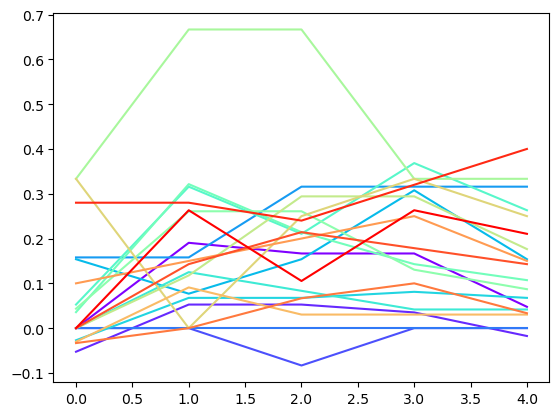

In [76]:
x = [(-i+4)%5 for i in range(100)]
colors = cm.rainbow(np.linspace(0, 1, 20))
for i in range(20):
    plt.plot(x[i*5:(i+1)*5], our_translations_scores[i*5:(i+1)*5], color = colors[i])
plt.show()

[0.06344653564309642, 0.11238755044122524, 0.1416554354540961, 0.16737870180355707, 0.13100718201293649]


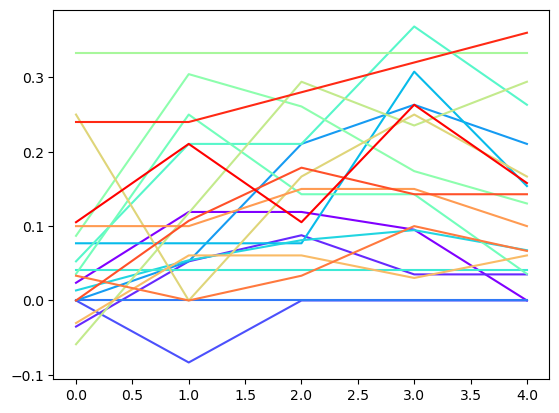

In [77]:
mean2 = [0, 0, 0, 0, 0]
for i in range(20):
    for j in range(5):
        mean2[4-j] += 1/20 * our_translations_scores2[i*5+j] 
print(mean2)

for i in range(20):
    plt.plot(x[i*5:(i+1)*5], our_translations_scores2[i*5:(i+1)*5], color = colors[i])
plt.show()

In [78]:
en_fr_df["translation_score1"] = our_translations_scores
en_fr_df["translation_score2"] = our_translations_scores2
en_fr_df.to_csv("en_to_fr_translations2.csv")

In [29]:
print(en_fr_df.iloc[10, 1])
print('\n')
print(en_fr_df.iloc[10, 2])
print('\n')
print(en_fr_df.iloc[11, 2])
print('\n')
print(en_fr_df.iloc[12, 2])
print('\n')
print(en_fr_df.iloc[13, 2])
print('\n')
print(en_fr_df.iloc[14, 2])

Sa formation universitaire et ses dons pour la rhétorique se complétaient l'un l'autre pour former un tout unique.




IndexError: index 2 is out of bounds for axis 0 with size 2

In [30]:
study_results(10, mbert_model, mbert_tokenizer, fr_translations, en_sentences)

NameError: name 'study_results' is not defined

In [33]:
print(en_fr_df.iloc[15, 1])
print('\n')
print(en_fr_df.iloc[15, 2])
print('\n')
print(en_fr_df.iloc[16, 2])
print('\n')
print(en_fr_df.iloc[17, 2])
print('\n')
print(en_fr_df.iloc[18, 2])
print('\n')
print(en_fr_df.iloc[19, 2])

Alas, there is no single or silver bullet.


Hélas, il n'existe aucune solution miracle.


Hélas, il n'existe pas de solution unique ou miracle.


Hélas, la solution miracle n'est pas existante.


Malheureusement, il n'y a pas de balle argentée.


n'existe Hélas, miracle. aucune solution il


In [36]:
study_results(17, mbert_model, mbert_tokenizer, fr_translations, en_sentences)

sentence :  Alas, there is no single or silver bullet.
translation :  Hélas, la solution miracle n'est pas existante.
tokenization of sentence :  ['alas', ',', 'there', 'is', 'no', 'single', 'or', 'silver', 'bullet', '.']
tokenization of trans. :  ['hela', '##s', ',', 'la', 'solution', 'miracle', 'n', "'", 'est', 'pas', 'exista', '##nte', '.']


['[MASK]', ',', 'there', 'is', 'no', 'single', 'or', 'silver', 'bullet', '.']
predicted_word_base[0]: however
predicted_word_help[0]: however
sentence[0]: alas
['alas', ',', 'there', 'is', 'no', 'single', 'or', '[MASK]', 'bullet', '.']
predicted_word_base[7]: no
predicted_word_help[7]: double
sentence[7]: silver
['alas', ',', '[MASK]', 'is', 'no', 'single', 'or', 'silver', '[MASK]', '.']
predicted_word_base[2]: there
predicted_word_help[2]: there
sentence[2]: there
predicted_word_base[8]: .
predicted_word_help[8]: solution
sentence[8]: bullet
['alas', ',', 'there', 'is', 'no', 'single', 'or', 'silver', 'bullet', '.']
['alas', ',', 'there', 'is'

## Running the Program

In [13]:
BLANC_help(fr_sentences[4], en_translations[4], mbert_model, mbert_tokenizer)

['[MASK]', '##s', 'ceux', 'fa', '##hd', ',', 'six', 'dirige', '##ant', 'dans', 'sou', '##tenir', 'en', 'dit', 'qu', "'", 'abd', '##alla', '[MASK]', 'sont', 'deti', '##ennent', 'presque', 'du', '[MASK]', ',', 'rien', 'ou', 'les', 'de', '[MASK]', '.', 'nom', 'grave', '##ment', 'sao', '[MASK]', '##te', ',', 'soit', 'le', 'generalement', '[MASK]', '##ment', 'cette', 'les', '"', 'sou', '[MASK]', '##ris', '"', ',', 'ses', 'le', 'du', 'de', 'freres', 'pouvoir', 'qui', 'rennes', '[MASK]', 'proposition', '.', 'le', 're', '##jete', '[MASK]', 'n', "'", 'ont', 'comme', 'malade', ',', 'roi', 'pour', 'considere', 'roi', 'occident', 'le', 'vraiment', 'l', "'", 'arabie', 'germain', '[MASK]', 'bien', 'et']
predicted_word_base[0]: ou
predicted_word_help[0]: ses
sentence[0]: reconnu
predicted_word_base[18]: ##h
predicted_word_help[18]: ##h
sentence[18]: ##h
predicted_word_base[24]: bien
predicted_word_help[24]: pouvoir
sentence[24]: freres
predicted_word_base[30]: freres
predicted_word_help[30]: freres
s

0.0

In [31]:
def study_results(index = 253, model = mbert_model, tokenizer = mbert_tokenizer, translations = en_translations, sentences = fr_sentences):
    print("sentence : ", en_fr_df['en'].iloc[index])
    print("translation : ", en_fr_df['fr'].iloc[index])
    print("tokenization of sentence : ",sentences[index])
    print("tokenization of trans. : ", translations[index])
    print('\n')
    print(BLANC_help(sentences[index], translations[index], model, tokenizer))

NameError: name 'en_translations' is not defined

In [12]:
%%time
en_fr_scores = [BLANC_help(sentence, translation, mbert_model, mbert_tokenizer)
          for sentence, translation in zip(fr_sentences, en_translations)]

['lor', 'a', '<', 'num', '>', '<', 'num', '>', 'dollars', 'lon', '##ce']
['lor', 'a', '<', 'num', '>', '<', 'num', '>', 'dollars', 'lon', '##ce']
['lor', 'a', '<', 'num', '>', '<', 'num', '>', '[MASK]', 'lon', '##ce']
predicted_word_base[8]: <
predicted_word_help[8]: .
sentence[8]: dollars
['lor', 'a', '<', 'num', '>', '<', 'num', '>', 'dollars', '[MASK]', '##ce']
predicted_word_base[9]: ##ce
predicted_word_help[9]: ##ee
sentence[9]: lon
['lor', 'a', '<', 'num', '>', '<', 'num', '>', 'dollars', 'lon', '[MASK]']
predicted_word_base[10]: ##d
predicted_word_help[10]: ##d
sentence[10]: ##ce
['lor', 'a', '<', 'num', '>', '<', 'num', '>', 'dollars', 'lon', '##ce']
['san', 'francisco', 'il', 'na', 'jamais', 'ete', '[MASK]', 'da', '##voir', 'une', 'discussion', 'ratio', '[MASK]', '##lle', 'sur', 'la', 'valeur', 'du', '[MASK]', 'jaune']
predicted_word_base[6]: a
predicted_word_help[6]: a
sentence[6]: facile
predicted_word_base[12]: ##nne
predicted_word_help[12]: ##nne
sentence[12]: ##nne
predic

In [31]:
for i in range(len(en_fr_scores)):
    print(f"{i} : {en_fr_scores[i]}")

good : 1, 44, 53, 60, 103, 112, 116, 129, 140, 147, 152, 161, 183, 186, 208, 237, 263, 264, 286
bad : 67, 82, 94, 164, 289
nul : 0, 2, 6, 13, 23, 29, 30

0 : 0.0
1 : 0.25
2 : 0.0
3 : 0.19444444444444445
4 : 0.0
5 : 0.05263157894736842
6 : 0.0
7 : -0.05
8 : 0.038461538461538464
9 : 0.0
10 : 0.0
11 : 0.05263157894736842
12 : 0.04
13 : 0.0
14 : 0.10526315789473684
15 : 0.08333333333333333
16 : 0.14285714285714285
17 : 0.05128205128205128
18 : 0.16666666666666666
19 : 0.05555555555555555
20 : 0.13043478260869565
21 : 0.16
22 : 0.058823529411764705
23 : 0.0
24 : 0.03225806451612903
25 : 0.13043478260869565
26 : 0.0
27 : 0.0
28 : 0.15789473684210525
29 : 0.0
30 : 0.0
31 : 0.037037037037037035
32 : 0.0
33 : 0.06666666666666667
34 : 0.11764705882352941
35 : 0.07692307692307693
36 : -0.09090909090909091
37 : 0.05263157894736842
38 : -0.045454545454545456
39 : 0.08695652173913043
40 : 0.07692307692307693
41 : 0.0
42 : 0.07407407407407407
43 : 0.0
44 : 0.2727272727272727
45 : 0.045454545454545456
46 : 0
47 : 0.2222222222222222
48 : 0.07407407407407407
49 : 0.07407407407407407
50 : 0.21428571428571427
51 : 0.11428571428571428
52 : 0.157894736842105

In [32]:
# good results 1
study_results(1, mbert_model, mbert_tokenizer)

# test below proves that litteral translation have better results than more nuanced translations.

sentence :  san francisco il na jamais ete facile davoir une discussion rationnelle sur la valeur du metal jaune
translation :  san francisco it has never been easy to have a rational conversation about the value of gold
tokenization of sentence :  ['san', 'francisco', 'il', 'na', 'jamais', 'ete', 'facile', 'da', '##voir', 'une', 'discussion', 'ratio', '##nne', '##lle', 'sur', 'la', 'valeur', 'du', 'metal', 'jaune']
tokenization of trans. :  ['san', 'francisco', 'it', 'has', 'never', 'been', 'easy', 'to', 'have', 'a', 'rational', 'conversation', 'about', 'the', 'value', 'of', 'gold']


['san', 'francisco', 'il', 'na', 'jamais', 'ete', '[MASK]', 'da', '##voir', 'une', 'discussion', 'ratio', '[MASK]', '##lle', 'sur', 'la', 'valeur', 'du', '[MASK]', 'jaune']
predicted_word_base[6]: a
predicted_word_help[6]: a
sentence[6]: facile
predicted_word_base[12]: ##nne
predicted_word_help[12]: ##nne
sentence[12]: ##nne
predicted_word_base[18]: drapeau
predicted_word_help[18]: diamant
sentence[18]: 

In [14]:
# test : translation from reverso

trans = mbert_tokenizer.tokenize("san francisco il na jamais ete facile davoir une discussion rationnelle sur la valeur du metal jaune")
sent = mbert_tokenizer.tokenize("it was never easy to have a rational discussion about the value of yellow metal")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

#

trans = mbert_tokenizer.tokenize("san francisco il na jamais ete facile davoir une discussion rationnelle sur la valeur du metal jaune")
sent = mbert_tokenizer.tokenize("it has never been easy to have a rational discussion about the value of yellow metal")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')



['san', 'francisco', 'il', 'na', 'jamais', 'ete', '[MASK]', 'da', '##voir', 'une', 'discussion', 'ratio', '[MASK]', '##lle', 'sur', 'la', 'valeur', 'du', '[MASK]', 'jaune']
predicted_word_base[6]: a
predicted_word_help[6]: a
sentence[6]: facile
predicted_word_base[12]: ##nne
predicted_word_help[12]: ##nne
sentence[12]: ##nne
predicted_word_base[18]: drapeau
predicted_word_help[18]: metal
sentence[18]: metal
['san', '[MASK]', 'il', 'na', 'jamais', 'ete', 'facile', '[MASK]', '##voir', 'une', 'discussion', 'ratio', '##nne', '[MASK]', 'sur', 'la', 'valeur', 'du', 'metal', '[MASK]']
predicted_word_base[1]: .
predicted_word_help[1]: francisco
sentence[1]: francisco
predicted_word_base[7]: entre
predicted_word_help[7]: entre
sentence[7]: da
predicted_word_base[13]: ##lle
predicted_word_help[13]: ##lle
sentence[13]: ##lle
predicted_word_base[19]: .
predicted_word_help[19]: .
sentence[19]: jaune
['san', 'francisco', 'il', 'na', 'jamais', 'ete', 'facile', 'da', '[MASK]', 'une', 'discussion', 'ra

In [36]:
# good results 2
study_results(44, mbert_model, mbert_tokenizer)

# literal translation

sentence :  bien sur toutes ces considerations pourraient navoir aucune influence sur le cours de lor
translation :  of course such considerations might have little influence on prices
tokenization of sentence :  ['bien', 'sur', 'toutes', 'ces', 'consideration', '##s', 'pour', '##raient', 'nav', '##oir', 'aucune', 'influence', 'sur', 'le', 'cours', 'de', 'lor']
tokenization of trans. :  ['of', 'course', 'such', 'consideration', '##s', 'might', 'have', 'little', 'influence', 'on', 'prices']


['[MASK]', 'sur', 'toutes', 'ces', 'consideration', '##s', '[MASK]', '##raient', 'nav', '##oir', 'aucune', 'influence', 'sur', 'le', 'cours', 'de', 'lor']
predicted_word_base[0]: .
predicted_word_help[0]: mais
sentence[0]: bien
predicted_word_base[6]: pour
predicted_word_help[6]: pour
sentence[6]: pour
['bien', 'sur', 'toutes', 'ces', 'consideration', '##s', 'pour', '[MASK]', 'nav', '##oir', 'aucune', 'influence', 'sur', 'le', 'cours', 'de', 'lor']
predicted_word_base[7]: ne
predicted_word_help[7]:

In [37]:
# good results 3
study_results(53, mbert_model, mbert_tokenizer)

# the first "chute" was not found because of the word "house" in the translation, unnecessary word that misled the model.
# limitation of the method itself (nedd for correlation)

sentence :  certes la chute de lehman brothers na rien a voir avec la chute du mur de berlin
translation :  of course the fall of the house of lehman brothers has nothing to do with the fall of the berlin wall
tokenization of sentence :  ['cert', '##es', 'la', 'chute', 'de', 'le', '##hman', 'brothers', 'na', 'rien', 'a', 'voir', 'avec', 'la', 'chute', 'du', 'mur', 'de', 'berlin']
tokenization of trans. :  ['of', 'course', 'the', 'fall', 'of', 'the', 'house', 'of', 'le', '##hman', 'brothers', 'has', 'nothing', 'to', 'do', 'with', 'the', 'fall', 'of', 'the', 'berlin', 'wall']


['[MASK]', '##es', 'la', 'chute', 'de', 'le', '[MASK]', 'brothers', 'na', 'rien', 'a', 'voir', '[MASK]', 'la', 'chute', 'du', 'mur', 'de', '[MASK]']
predicted_word_base[0]: .
predicted_word_help[0]: annex
sentence[0]: cert
predicted_word_base[6]: grand
predicted_word_help[6]: ##hman
sentence[6]: ##hman
predicted_word_base[12]: avec
predicted_word_help[12]: avec
sentence[12]: avec
predicted_word_base[18]: londres
p

In [39]:
# test

# translation from reverso
trans = mbert_tokenizer.tokenize("certes la chute de lehman brothers na rien a voir avec la chute du mur de berlin")
sent = mbert_tokenizer.tokenize("certainly the fall of lehman brothers has nothing to do with the fall of the berlin wall")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

# translation from deepl
trans = mbert_tokenizer.tokenize("certes la chute de lehman brothers na rien a voir avec la chute du mur de berlin")
sent = mbert_tokenizer.tokenize("of course, the fall of Lehman Brothers had nothing to do with the fall of the Berlin Wall")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

['[MASK]', '##es', 'la', 'chute', 'de', 'le', '[MASK]', 'brothers', 'na', 'rien', 'a', 'voir', '[MASK]', 'la', 'chute', 'du', 'mur', 'de', '[MASK]']
predicted_word_base[0]: .
predicted_word_help[0]: annex
sentence[0]: cert
predicted_word_base[6]: grand
predicted_word_help[6]: ##hman
sentence[6]: ##hman
predicted_word_base[12]: avec
predicted_word_help[12]: avec
sentence[12]: avec
predicted_word_base[18]: detroit
predicted_word_help[18]: berlin
sentence[18]: berlin
['cert', '[MASK]', 'la', 'chute', 'de', 'le', '##hman', '[MASK]', 'na', 'rien', 'a', 'voir', 'avec', 'la', 'chute', 'du', 'mur', 'de', 'berlin']
predicted_word_base[1]: ##es
predicted_word_help[1]: ##es
sentence[1]: ##es
predicted_word_base[7]: ##berg
predicted_word_help[7]: brothers
sentence[7]: brothers
['cert', '##es', 'la', 'chute', 'de', 'le', '##hman', 'brothers', 'na', 'rien', 'a', 'voir', 'avec', 'la', '[MASK]', 'du', 'mur', 'de', 'berlin']
predicted_word_base[14]: chute
predicted_word_help[14]: chute
sentence[14]: ch

In [42]:
# good results 4
study_results(60, mbert_model, mbert_tokenizer)

# need for position

sentence :  les differences sont evidentes entre <NUM> et aujourdhui
translation :  of course there are obvious differences between <NUM> and now
tokenization of sentence :  ['les', 'differences', 'sont', 'evidente', '##s', 'entre', '<', 'num', '>', 'et', 'aujourd', '##hu', '##i']
tokenization of trans. :  ['of', 'course', 'there', 'are', 'obvious', 'differences', 'between', '<', 'num', '>', 'and', 'now']


['les', 'differences', 'sont', 'evidente', '##s', 'entre', '<', 'num', '>', 'et', 'aujourd', '##hu', '[MASK]']
predicted_word_base[12]: hui
predicted_word_help[12]: ##x
sentence[12]: ##i
['les', '[MASK]', 'sont', 'evidente', '##s', 'entre', '<', 'num', '>', 'et', 'aujourd', '##hu', '##i']
predicted_word_base[1]: differences
predicted_word_help[1]: differences
sentence[1]: differences
['les', 'differences', '[MASK]', 'evidente', '##s', 'entre', '<', 'num', '>', 'et', 'aujourd', '##hu', '##i']
predicted_word_base[2]: plus
predicted_word_help[2]: sont
sentence[2]: sont
['les', 'differe

In [15]:
# test

# without unnecessary word
trans = mbert_tokenizer.tokenize("les differences sont evidentes entre <NUM> et aujourdhui")
sent = mbert_tokenizer.tokenize("there are obvious differences between <NUM> and now")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')
# the "of course" add a generality to the sentence. the sentence without it is somehow not complete.
# proof that the method can detect lesser good translations.

# translation from reverso
trans = mbert_tokenizer.tokenize("les differences sont evidentes entre <NUM> et aujourdhui")
sent = mbert_tokenizer.tokenize("differences are evident between <NUM> and today")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

# translation from deepl
trans = mbert_tokenizer.tokenize("les differences sont evidentes entre <NUM> et aujourdhui")
sent = mbert_tokenizer.tokenize("the differences between <NUM> and today are obvious")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

['les', 'differences', 'sont', 'evidente', '##s', 'entre', '<', 'num', '>', 'et', 'aujourd', '##hu', '[MASK]']
predicted_word_base[12]: hui
predicted_word_help[12]: ##x
sentence[12]: ##i
['les', '[MASK]', 'sont', 'evidente', '##s', 'entre', '<', 'num', '>', 'et', 'aujourd', '##hu', '##i']
predicted_word_base[1]: differences
predicted_word_help[1]: differences
sentence[1]: differences
['les', 'differences', '[MASK]', 'evidente', '##s', 'entre', '<', 'num', '>', 'et', 'aujourd', '##hu', '##i']
predicted_word_base[2]: plus
predicted_word_help[2]: plus
sentence[2]: sont
['les', 'differences', 'sont', '[MASK]', '##s', 'entre', '<', 'num', '>', 'et', 'aujourd', '##hu', '##i']
predicted_word_base[3]: marquee
predicted_word_help[3]: evidente
sentence[3]: evidente
['les', 'differences', 'sont', 'evidente', '[MASK]', 'entre', '<', 'num', '>', 'et', '[MASK]', '##hu', '##i']
predicted_word_base[4]: ##s
predicted_word_help[4]: ##s
sentence[4]: ##s
predicted_word_base[10]: wu
predicted_word_help[10]

In [46]:
# good results 5
study_results(103, mbert_model, mbert_tokenizer)

# literal

sentence :  le reve europeen est en crise
translation :  the european dream is in crisis
tokenization of sentence :  ['le', 'reve', 'europeen', 'est', 'en', 'crise']
tokenization of trans. :  ['the', 'european', 'dream', 'is', 'in', 'crisis']


['le', 'reve', 'europeen', 'est', 'en', 'crise']
['le', '[MASK]', 'europeen', 'est', 'en', 'crise']
predicted_word_base[1]: parlement
predicted_word_help[1]: monde
sentence[1]: reve
['le', 'reve', '[MASK]', 'est', 'en', 'crise']
predicted_word_base[2]: ##il
predicted_word_help[2]: ##il
sentence[2]: europeen
['le', 'reve', 'europeen', 'est', 'en', 'crise']
['le', 'reve', 'europeen', 'est', 'en', 'crise']
['le', 'reve', 'europeen', 'est', 'en', '[MASK]']
predicted_word_base[5]: fait
predicted_word_help[5]: crise
sentence[5]: crise
0.3333333333333333


In [47]:
# good results 6
study_results(112, mbert_model, mbert_tokenizer)

# uninteresting

sentence :  neanmoins beaucoup dautres choses seffondrent avec le modele sovietique
translation :  but much else collapsed with the soviet model
tokenization of sentence :  ['neanmoins', 'beaucoup', 'dau', '##tres', 'choses', 'sef', '##fondre', '##nt', 'avec', 'le', 'modele', 'sovietique']
tokenization of trans. :  ['but', 'much', 'else', 'collapsed', 'with', 'the', 'soviet', 'model']


['[MASK]', 'beaucoup', 'dau', '##tres', 'choses', 'sef', '[MASK]', '##nt', 'avec', 'le', 'modele', 'sovietique']
predicted_word_base[0]: .
predicted_word_help[0]: mais
sentence[0]: neanmoins
predicted_word_base[6]: concorde
predicted_word_help[6]: tombe
sentence[6]: ##fondre
['neanmoins', '[MASK]', 'dau', '##tres', 'choses', 'sef', '##fondre', '[MASK]', 'avec', 'le', 'modele', 'sovietique']
predicted_word_base[1]: ,
predicted_word_help[1]: ,
sentence[1]: beaucoup
predicted_word_base[7]: ##nt
predicted_word_help[7]: ##nt
sentence[7]: ##nt
['neanmoins', 'beaucoup', '[MASK]', '##tres', 'choses', 'sef', '##

In [48]:
# test

# translation from reverso
trans = mbert_tokenizer.tokenize("neanmoins beaucoup dautres choses seffondrent avec le modele sovietique")
sent = mbert_tokenizer.tokenize("but many other things collapse with the Soviet model")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

# translation from deepl
trans = mbert_tokenizer.tokenize("neanmoins beaucoup dautres choses seffondrent avec le modele sovietique")
sent = mbert_tokenizer.tokenize("however, many other things collapse with the soviet model")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

['[MASK]', 'beaucoup', 'dau', '##tres', 'choses', 'sef', '[MASK]', '##nt', 'avec', 'le', 'modele', 'sovietique']
predicted_word_base[0]: .
predicted_word_help[0]: ...
sentence[0]: neanmoins
predicted_word_base[6]: concorde
predicted_word_help[6]: ##fondre
sentence[6]: ##fondre
['neanmoins', '[MASK]', 'dau', '##tres', 'choses', 'sef', '##fondre', '[MASK]', 'avec', 'le', 'modele', 'sovietique']
predicted_word_base[1]: ,
predicted_word_help[1]: ,
sentence[1]: beaucoup
predicted_word_base[7]: ##nt
predicted_word_help[7]: ##nt
sentence[7]: ##nt
['neanmoins', 'beaucoup', '[MASK]', '##tres', 'choses', 'sef', '##fondre', '##nt', '[MASK]', 'le', 'modele', 'sovietique']
predicted_word_base[2]: de
predicted_word_help[2]: de
sentence[2]: dau
predicted_word_base[8]: sur
predicted_word_help[8]: avec
sentence[8]: avec
['neanmoins', 'beaucoup', 'dau', '[MASK]', 'choses', 'sef', '##fondre', '##nt', 'avec', 'le', 'modele', 'sovietique']
predicted_word_base[3]: ces
predicted_word_help[3]: autres
sentence

In [50]:
# bad results 1
study_results(67, mbert_model, mbert_tokenizer)

# weird choice of words, the idea is here but diverted

sentence :  on percoit lemergence dun monde domine par lamerique et lasie
translation :  one senses something like the making of an american asian dominated universe
tokenization of sentence :  ['on', 'per', '##co', '##it', 'lem', '##erg', '##ence', 'dun', 'monde', 'domine', 'par', 'lam', '##eri', '##que', 'et', 'las', '##ie']
tokenization of trans. :  ['one', 'sense', '##s', 'something', 'like', 'the', 'making', 'of', 'an', 'american', 'asian', 'dominated', 'universe']


['on', 'per', '##co', '##it', 'lem', '##erg', '[MASK]', 'dun', 'monde', 'domine', 'par', 'lam', '[MASK]', '##que', 'et', 'las', '##ie']
predicted_word_base[6]: ##e
predicted_word_help[6]: ##e
sentence[6]: ##ence
predicted_word_base[12]: ##es
predicted_word_help[12]: ##es
sentence[12]: ##eri
['on', '[MASK]', '##co', '##it', 'lem', '##erg', '##ence', 'dun', 'monde', 'domine', 'par', 'lam', '##eri', '[MASK]', 'et', 'las', '##ie']
predicted_word_base[1]: per
predicted_word_help[1]: es
sentence[1]: per
predicted_word_base[

In [16]:
# test

#
trans = mbert_tokenizer.tokenize("on percoit lemergence dun monde domine par lamerique et lasie")
sent = mbert_tokenizer.tokenize("one senses the emergence of a world dominated by america and asia.")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

# translation from reverso
trans = mbert_tokenizer.tokenize("on percoit lemergence dun monde domine par lamerique et lasie")
sent = mbert_tokenizer.tokenize("we perceive the emergence of a world dominated by America and Asia.")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

# translation from deepl
trans = mbert_tokenizer.tokenize("on percoit lemergence dun monde domine par lamerique et lasie")
sent = mbert_tokenizer.tokenize("we can see the emergence of a world dominated by america and asia.")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

['on', 'per', '##co', '##it', 'lem', '##erg', '[MASK]', 'dun', 'monde', 'domine', 'par', 'lam', '[MASK]', '##que', 'et', 'las', '##ie']
predicted_word_base[6]: ##e
predicted_word_help[6]: ##e
sentence[6]: ##ence
predicted_word_base[12]: ##es
predicted_word_help[12]: ##es
sentence[12]: ##eri
['on', '[MASK]', '##co', '##it', 'lem', '##erg', '##ence', 'dun', 'monde', 'domine', 'par', 'lam', '##eri', '[MASK]', 'et', 'las', '##ie']
predicted_word_base[1]: per
predicted_word_help[1]: con
sentence[1]: per
predicted_word_base[13]: ##on
predicted_word_help[13]: ##on
sentence[13]: ##que
['on', 'per', '[MASK]', '##it', 'lem', '##erg', '##ence', 'dun', '[MASK]', 'domine', 'par', 'lam', '##eri', '##que', 'et', 'las', '##ie']
predicted_word_base[2]: ##co
predicted_word_help[2]: ##co
sentence[2]: ##co
predicted_word_base[8]: ,
predicted_word_help[8]: ,
sentence[8]: monde
['on', 'per', '##co', '[MASK]', 'lem', '##erg', '##ence', 'dun', 'monde', '[MASK]', 'par', 'lam', '##eri', '##que', 'et', '[MASK]',

In [57]:
# bad results 2
study_results(82, mbert_model, mbert_tokenizer)

# very sensitive to verbs tense + too much info with the simply

sentence :  hommes et femmes nont alors pas risque leur vie pour retrouver la vielle epoque des privileges de classe et de la privation sociale
translation :  men and women had not risked their lives simply to return to the old days of class privilege and social deprivation
tokenization of sentence :  ['hommes', 'et', 'femmes', 'non', '##t', 'alors', 'pas', 'risque', 'leur', 'vie', 'pour', 'retrouver', 'la', 'viel', '##le', 'epoque', 'des', 'privileges', 'de', 'classe', 'et', 'de', 'la', 'privat', '##ion', 'sociale']
tokenization of trans. :  ['men', 'and', 'women', 'had', 'not', 'risk', '##ed', 'their', 'lives', 'simply', 'to', 'return', 'to', 'the', 'old', 'days', 'of', 'class', 'pri', '##vil', '##ege', 'and', 'social', 'de', '##pri', '##vati', '##on']


['[MASK]', 'et', 'femmes', 'non', '##t', 'alors', 'pas', 'risque', 'leur', 'vie', 'pour', 'retrouver', 'la', 'viel', '##le', 'epoque', 'des', 'privileges', 'de', 'classe', 'et', 'de', 'la', 'privat', '[MASK]', 'sociale']
predicted_wo

In [17]:
# test

# translation from reverso
trans = mbert_tokenizer.tokenize("hommes et femmes nont alors pas risque leur vie pour retrouver la vielle epoque des privileges de classe et de la privation sociale")
sent = mbert_tokenizer.tokenize("men and women did not risk their lives to regain the old era of class privileges and social deprivation.")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

# translation from deepl
trans = mbert_tokenizer.tokenize("hommes et femmes nont alors pas risque leur vie pour retrouver la vielle epoque des privileges de classe et de la privation sociale")
sent = mbert_tokenizer.tokenize("men and women did not risk their lives to return to the old days of class privilege and social deprivation.")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

#
trans = mbert_tokenizer.tokenize("hommes et femmes nont alors pas risque leur vie pour retrouver la vielle epoque des privileges de classe et de la privation sociale")
sent = mbert_tokenizer.tokenize("men and women did not risk their lives simply to return to the old days of class privilege and social deprivation.")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

['[MASK]', 'et', 'femmes', 'non', '##t', 'alors', 'pas', 'risque', 'leur', 'vie', 'pour', 'retrouver', 'la', 'viel', '##le', 'epoque', 'des', 'privileges', 'de', 'classe', 'et', 'de', 'la', 'privat', '[MASK]', 'sociale']
predicted_word_base[0]: hommes
predicted_word_help[0]: »
sentence[0]: hommes
predicted_word_base[24]: ##ion
predicted_word_help[24]: ##ion
sentence[24]: ##ion
['hommes', 'et', 'femmes', 'non', '##t', 'alors', 'pas', '[MASK]', 'leur', 'vie', 'pour', 'retrouver', 'la', '[MASK]', '##le', 'epoque', 'des', 'privileges', 'de', '[MASK]', 'et', 'de', 'la', 'privat', '##ion', '[MASK]']
predicted_word_base[7]: dans
predicted_word_help[7]: perdre
sentence[7]: risque
predicted_word_base[13]: soup
predicted_word_help[13]: soup
sentence[13]: viel
predicted_word_base[19]: mariage
predicted_word_help[19]: propriete
sentence[19]: classe
predicted_word_base[25]: .
predicted_word_help[25]: des
sentence[25]: sociale
['hommes', 'et', '[MASK]', 'non', '##t', 'alors', 'pas', 'risque', '[MASK

In [59]:
# bad results 2
study_results(94, mbert_model, mbert_tokenizer)

# not literal enough and bad wording

sentence :  tout comme le reve dunite europeenne lonu fait partie integrante du consensus de <NUM>
translation :  the un like the dream of european unity was also part of the <NUM> consensus
tokenization of sentence :  ['tout', 'comme', 'le', 'reve', 'dun', '##ite', 'europeenne', 'lon', '##u', 'fait', 'partie', 'integrante', 'du', 'consensus', 'de', '<', 'num', '>']
tokenization of trans. :  ['the', 'un', 'like', 'the', 'dream', 'of', 'european', 'unity', 'was', 'also', 'part', 'of', 'the', '<', 'num', '>', 'consensus']


['[MASK]', 'comme', 'le', 'reve', 'dun', '##ite', '[MASK]', 'lon', '##u', 'fait', 'partie', 'integrante', 'du', 'consensus', 'de', '<', 'num', '>']
predicted_word_base[0]: .
predicted_word_help[0]: un
sentence[0]: tout
predicted_word_base[6]: ,
predicted_word_help[6]: de
sentence[6]: europeenne
['tout', '[MASK]', 'le', 'reve', 'dun', '##ite', 'europeenne', '[MASK]', '##u', 'fait', 'partie', 'integrante', 'du', '[MASK]', 'de', '<', 'num', '>']
predicted_word_base[1]: c

In [18]:
# test

# translation from reverso
trans = mbert_tokenizer.tokenize("tout comme le reve dunite europeenne lonu fait partie integrante du consensus de <NUM>")
sent = mbert_tokenizer.tokenize("just as the dream of European unity the UN is an integral part of the consensus of <NUM>")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

# translation from deepl
trans = mbert_tokenizer.tokenize("tout comme le reve dunite europeenne lonu fait partie integrante du consensus de <NUM>")
sent = mbert_tokenizer.tokenize("like the dream of european unity, the un is an integral part of the consensus of <NUM>")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

['[MASK]', 'comme', 'le', 'reve', 'dun', '##ite', '[MASK]', 'lon', '##u', 'fait', 'partie', 'integrante', 'du', 'consensus', 'de', '<', 'num', '>']
predicted_word_base[0]: .
predicted_word_help[0]: .
sentence[0]: tout
predicted_word_base[6]: ,
predicted_word_help[6]: ,
sentence[6]: europeenne
['tout', '[MASK]', 'le', 'reve', 'dun', '##ite', 'europeenne', '[MASK]', '##u', 'fait', 'partie', 'integrante', 'du', '[MASK]', 'de', '<', 'num', '>']
predicted_word_base[1]: comme
predicted_word_help[1]: comme
sentence[1]: comme
predicted_word_base[7]: em
predicted_word_help[7]: em
sentence[7]: lon
predicted_word_base[13]: groupe
predicted_word_help[13]: consensus
sentence[13]: consensus
['tout', 'comme', 'le', 'reve', 'dun', '##ite', 'europeenne', 'lon', '[MASK]', 'fait', 'partie', 'integrante', 'du', 'consensus', 'de', '<', 'num', '>']
predicted_word_base[8]: ##a
predicted_word_help[8]: un
sentence[8]: ##u
['tout', 'comme', 'le', '[MASK]', 'dun', '##ite', 'europeenne', 'lon', '##u', '[MASK]', '

In [64]:
# bad results 4
study_results(164, mbert_model, mbert_tokenizer)

# not literal enough

sentence :  nous aurions tort de considerer la lutte contre le terrorisme comme lobjectif principal des politiques menees autour du monde par les gouvernements en charge
translation :  it is and would be wrong to make opposition to terrorism the centerpiece of what responsible governments do in the world
tokenization of sentence :  ['nous', 'aur', '##ions', 'tort', 'de', 'considere', '##r', 'la', 'lutte', 'contre', 'le', 'terrorism', '##e', 'comme', 'lo', '##b', '##ject', '##if', 'principal', 'des', 'politiques', 'menee', '##s', 'autour', 'du', 'monde', 'par', 'les', 'gouvernement', '##s', 'en', 'charge']
tokenization of trans. :  ['it', 'is', 'and', 'would', 'be', 'wrong', 'to', 'make', 'opposition', 'to', 'terrorism', 'the', 'center', '##piece', 'of', 'what', 'responsible', 'governments', 'do', 'in', 'the', 'world']


['[MASK]', 'aur', '##ions', 'tort', 'de', 'considere', '[MASK]', 'la', 'lutte', 'contre', 'le', 'terrorism', '[MASK]', 'comme', 'lo', '##b', '##ject', '##if', '[MASK]',

In [71]:
# test

# translation from reverso
trans = mbert_tokenizer.tokenize("nous aurions tort de considerer la lutte contre le terrorisme comme lobjectif principal des politiques menees autour du monde par les gouvernements en charge")
sent = mbert_tokenizer.tokenize("we would be wrong to consider the fight against terrorism as the main objective of the policies carried out around the world by the governments in charge")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

# translation from deepl
trans = mbert_tokenizer.tokenize("nous aurions tort de considerer la lutte contre le terrorisme comme lobjectif principal des politiques menees autour du monde par les gouvernements en charge")
sent = mbert_tokenizer.tokenize("it would be a mistake to regard the fight against terrorism as the main objective of the policies pursued around the world by the governments in charge")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

# with punctuation
trans = mbert_tokenizer.tokenize("nous aurions tort de considerer la lutte contre le terrorisme comme lobjectif principal des politiques menees autour du monde par les gouvernements en charge")
sent = mbert_tokenizer.tokenize("it would be a mistake to regard the fight against terrorism as the main objective of the policies pursued around the world by the governments in charge.")

print(BLANC_help(trans, sent, mbert_model, mbert_tokenizer))
print('\n')

['[MASK]', 'aur', '##ions', 'tort', 'de', 'considere', '[MASK]', 'la', 'lutte', 'contre', 'le', 'terrorism', '[MASK]', 'comme', 'lo', '##b', '##ject', '##if', '[MASK]', 'des', 'politiques', 'menee', '##s', 'autour', 'du', 'monde', 'par', 'les', 'gouvernement', '##s', 'en', 'charge']
predicted_word_base[0]: nous
predicted_word_help[0]: nous
sentence[0]: nous
predicted_word_base[6]: ##r
predicted_word_help[6]: ##r
sentence[6]: ##r
predicted_word_base[12]: ##e
predicted_word_help[12]: ##e
sentence[12]: ##e
predicted_word_base[18]: lors
predicted_word_help[18]: ##ique
sentence[18]: principal
['nous', '[MASK]', '##ions', 'tort', 'de', 'considere', '##r', 'la', 'lutte', 'contre', 'le', 'terrorism', '##e', '[MASK]', 'lo', '##b', '##ject', '##if', 'principal', 'des', 'politiques', 'menee', '##s', 'autour', 'du', '[MASK]', 'par', 'les', 'gouvernement', '##s', 'en', '[MASK]']
predicted_word_base[1]: aur
predicted_word_help[1]: sais
sentence[1]: aur
predicted_word_base[13]: comme
predicted_word_h

In [76]:
# bad results 5
study_results(289, mbert_model, mbert_tokenizer)

# non sense

sentence :  l u<NUM>isolement d u<NUM>abdallah
translation :  abdullah out on a limb
tokenization of sentence :  ['l', 'u', '<', 'num', '>', 'isole', '##ment', 'd', 'u', '<', 'num', '>', 'abd', '##alla', '##h']
tokenization of trans. :  ['abdullah', 'out', 'on', 'a', 'lim', '##b']


['l', 'u', '<', 'num', '>', 'isole', '[MASK]', 'd', 'u', '<', 'num', '>', '[MASK]', '##alla', '##h']
predicted_word_base[6]: .
predicted_word_help[6]: .
sentence[6]: ##ment
predicted_word_base[12]: abd
predicted_word_help[12]: abd
sentence[12]: abd
['l', 'u', '<', 'num', '>', 'isole', '##ment', 'd', 'u', '<', 'num', '>', 'abd', '[MASK]', '##h']
predicted_word_base[13]: ##alla
predicted_word_help[13]: ##onis
sentence[13]: ##alla
['l', 'u', '<', 'num', '>', 'isole', '##ment', 'd', 'u', '<', 'num', '>', 'abd', '##alla', '[MASK]']
predicted_word_base[14]: ##h
predicted_word_help[14]: ##h
sentence[14]: ##h
['l', 'u', '<', 'num', '>', 'isole', '##ment', 'd', 'u', '<', 'num', '>', 'abd', '##alla', '##h']
['l', 'u'

In [77]:
# null score 1
study_results(0, mbert_model, mbert_tokenizer)

# bad translation

sentence :  lor a <NUM> <NUM> dollars lonce
translation :  <NUM> <NUM> gold
tokenization of sentence :  ['lor', 'a', '<', 'num', '>', '<', 'num', '>', 'dollars', 'lon', '##ce']
tokenization of trans. :  ['<', 'num', '>', '<', 'num', '>', 'gold']


['lor', 'a', '<', 'num', '>', '<', 'num', '>', 'dollars', 'lon', '##ce']
['lor', 'a', '<', 'num', '>', '<', 'num', '>', 'dollars', 'lon', '##ce']
['lor', 'a', '<', 'num', '>', '<', 'num', '>', '[MASK]', 'lon', '##ce']
predicted_word_base[8]: <
predicted_word_help[8]: .
sentence[8]: dollars
['lor', 'a', '<', 'num', '>', '<', 'num', '>', 'dollars', '[MASK]', '##ce']
predicted_word_base[9]: ##ce
predicted_word_help[9]: ##ee
sentence[9]: lon
['lor', 'a', '<', 'num', '>', '<', 'num', '>', 'dollars', 'lon', '[MASK]']
predicted_word_base[10]: ##d
predicted_word_help[10]: ##d
sentence[10]: ##ce
['lor', 'a', '<', 'num', '>', '<', 'num', '>', 'dollars', 'lon', '##ce']
0.0


In [78]:
# null score 2
study_results(2, mbert_model, mbert_tokenizer)

# bad translation

sentence :  et aujourdhui alors que le cours de lor a augmente de <NUM> pour cent au cours de la derniere decennie cest plus difficile que jamais
translation :  lately with gold prices up more than <NUM> over the last decade it is harder than ever
tokenization of sentence :  ['et', 'aujourd', '##hu', '##i', 'alors', 'que', 'le', 'cours', 'de', 'lor', 'a', 'augmente', 'de', '<', 'num', '>', 'pour', 'cent', 'au', 'cours', 'de', 'la', 'derniere', 'decenni', '##e', 'cest', 'plus', 'difficile', 'que', 'jamais']
tokenization of trans. :  ['late', '##ly', 'with', 'gold', 'prices', 'up', 'more', 'than', '<', 'num', '>', 'over', 'the', 'last', 'decade', 'it', 'is', 'harder', 'than', 'ever']


['et', 'aujourd', '##hu', '##i', 'alors', 'que', 'le', 'cours', 'de', 'lor', 'a', 'augmente', 'de', '<', 'num', '>', 'pour', 'cent', 'au', 'cours', 'de', 'la', 'derniere', 'decenni', '[MASK]', 'cest', 'plus', 'difficile', 'que', 'jamais']
predicted_word_base[24]: ##e
predicted_word_help[24]: ##e
sentence[2

In [79]:
# null score 2
study_results(6, mbert_model, mbert_tokenizer)

# bad translation

sentence :  en decembre dernier plusieurs investisseurs dans le metal jaune estimaient que lonce atteindrait inevitablement les <NUM> dollars
translation :  last december many gold bugs were arguing that the price was inevitably headed for <NUM> <NUM>
tokenization of sentence :  ['en', 'decembre', 'dernier', 'plusieurs', 'in', '##vesti', '##sse', '##urs', 'dans', 'le', 'metal', 'jaune', 'estima', '##ient', 'que', 'lon', '##ce', 'atte', '##ind', '##rait', 'ine', '##vita', '##blement', 'les', '<', 'num', '>', 'dollars']
tokenization of trans. :  ['last', 'december', 'many', 'gold', 'bugs', 'were', 'arg', '##uing', 'that', 'the', 'price', 'was', 'ine', '##vita', '##bly', 'headed', 'for', '<', 'num', '>', '<', 'num', '>']


['en', 'decembre', 'dernier', 'plusieurs', 'in', '##vesti', '[MASK]', '##urs', 'dans', 'le', 'metal', 'jaune', '[MASK]', '##ient', 'que', 'lon', '##ce', 'atte', '[MASK]', '##rait', 'ine', '##vita', '##blement', 'les', '<', 'num', '>', 'dollars']
predicted_word_base[6]: 

In [31]:
# English - Persian (Farsi)

en_fa_ds = load_dataset('persiannlp/parsinlu_translation_en_fa', split='train')

# Removing the 'category' column
en_fa_ds = en_fa_ds.remove_columns(['category'])

# Removing list encapsulation
en_fa_ds = en_fa_ds.map(lambda example: {'targets': example['targets'][0]}, num_proc=4)

# Filtering out rows with the '\u200c' symbol and those where the length of either source or targets is less than a threshold
length_threshold = 10
filtered_en_fa_ds = en_fa_ds.filter(
    lambda example: '\u200c' not in example['targets']
    and len(example['source']) >= length_threshold
    and len(example['targets']) >= length_threshold,
    num_proc=4)

en_fa_df = pd.DataFrame(filtered_en_fa_ds[:300])
en_fa_df

Filter (num_proc=4):   0%|          | 0/1621665 [00:00<?, ? examples/s]

NameError: name 'length_threshold' is not defined

In [ ]:
# English - Persian (Farsi)
# change names here (to be more clear on what is translations what is sentences)
en_fa_sentences = [mbert_tokenizer.tokenize(sentence)
                   for sentence in en_fa_df['source']]  # (List[List[str]])

en_fa_translations = [mbert_tokenizer.tokenize(translation)
                      for translation in en_fa_df['targets']] # (List[List[str]])

In [1]:
BLANC_help(en_fa_translations[1], en_fa_sentences[1], mbert_model, mbert_tokenizer, device=DEVICE)

NameError: name 'BLANC_help' is not defined

In [ ]:
%%time
en_fa_scores = [BLANC_help(translation, sentence, mbert_model, mbert_tokenizer, device=DEVICE)
                for translation, sentence in tqdm(zip(en_fa_translations, en_fa_sentences), total=len(en_fa_sentences))]

In [ ]:
for i in range(len(en_fa_scores)):
    print(f"{i} : {en_fa_scores[i]}")

In [40]:
data = {}
data['BLANC_help_300_translation'] = en_fr_scores

import json

def add_results_to_json(new_data, file_path = "./results.json"):
    try:
        with open(file_path, 'r') as json_file:
            existing_data = json.load(json_file)
    except FileNotFoundError:
        existing_data = {}

    for key, value in new_data.items():
        existing_data[key] = value

    with open(file_path, 'w') as json_file:
        json.dump(existing_data, json_file, indent=2)

    print(f"Data has been added to {file_path}")

add_results_to_json(data)

Data has been added to ./results.json
